# Descriptor Function Examples

### Introduction

The purpose of this notebook is to demonstrate some examples of the peak descriptors function use. Each cell in this notebook will run from the sample data in this directory

### Installation guidelines

These functions require the following pip installs

```
pip install lmfit
pip install numpy
pip install pandas
pip install peakutils
pip install scipy
```
### Import statements

In [1]:
import sys
sys.path.insert(0, '../chachies')
import descriptors

## Fitting Class Examples

The examples below are codes used to develop the `fitting` class.

### File imports with chachifuncs

The following code was used to import a single cycle of data to this jupyter notebook

Text(0,0.5,'dQ/dV')

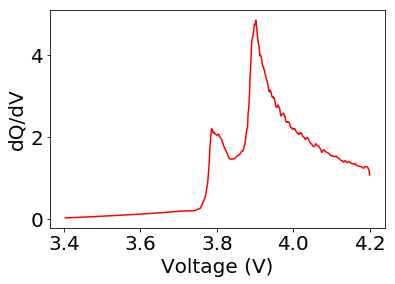

In [2]:
import chachifuncs as ccf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#reads a single excel spreadsheet into Jupyter
testdf = pd.read_excel('example_files/CS2_33_10_04_10-Cycle10Clean.xlsx')

#separates charge and discharge cycles using chachifuncs
charge, discharge = ccf.sep_char_dis(testdf)

#converts charge data to a pandas dataframe
sigx_bot = pd.to_numeric(charge['Voltage(V)']).as_matrix()
sigy_bot = pd.to_numeric(charge['Smoothed_dQ/dV']).as_matrix()

plt.rcParams.update({'font.size':20})
#fig, ax = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(sigx_bot, sigy_bot, 'r')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')

### Sub Component Examples

#### PeakUtils Peak Finder

This function uses the PeakUtils package to find all of the peaks in the dataset displayed above. An additional function `fitters.cd_dataframe` is used to flip the y data of the discharge curves and convert the pandas series used in `fitters.descriptor_func` to numpy arrays.

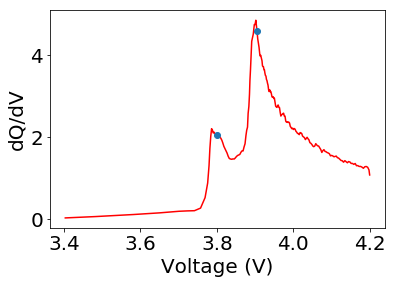

In [3]:
import peakutils
import scipy.signal

#applies additional level of smoothing to prevent indexing of false peaks
sigy_smooth = scipy.signal.savgol_filter(sigy_bot, 25, 3)

#determines indexes of peaks in the dataset
i = peakutils.indexes(sigy_smooth, thres=.3/max(sigy_bot), min_dist=9)

#plots data
plt.rcParams.update({'font.size':20})
plt.plot(sigx_bot, sigy_bot, 'r')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.plot(sigx_bot[i], sigy_bot[i], 'o')

#### lmfit model generation

The following cell creates model objects for use in the final fitting of the dQ/dV curve. 

In [4]:
from lmfit import models

#creates a polynomial fitting object
mod = models.PolynomialModel(4)

#sets polynomial parameters based on a
#guess of a polynomial fit to the data with no peaks
par = mod.guess(sigy_bot, x=sigx_bot)

#iterates over all peak indices
for index in i:
    
    #generates unique parameter strings based on index of peak
    pref = str(int(index))
    comb = 'a' + pref + '_'
    
    cent = 'center'
    sig = 'sigma'
    amp = 'amplitude'
    fract = 'fraction'
    
    #generates a pseudo voigt fitting model
    gaus_loop = models.PseudoVoigtModel(prefix=comb)
    par.update(gaus_loop.make_params())
    
    #uses unique parameter strings to generate parameters with initial guesses
    #in this model, the center of the peak is locked at the peak location determined from PeakUtils
    par[comb+cent].set(sigx_bot[index], vary=False)
    
    #the other initial parameters were found by trial and error
    par[comb+sig].set(0.01)
    par[comb+amp].set(.05, min=0)
    par[comb+fract].set(.5)
    
    #adds each pseudo voigt model to the polynomial model
    mod = mod + gaus_loop

#### Final fit generation

The following code uses the `mod` and `par` objects found above to determine the final fit to the battery cycle. The execution of this model is performed below:

[[Model]]
    ((Model(polynomial) + Model(pvoigt, prefix='a22_')) + Model(pvoigt, prefix='a64_'))
[[Fit Statistics]]
    # function evals   = 1021
    # data points      = 193
    # variables        = 11
    chi-square         = 8.038
    reduced chi-square = 0.044
    Akaike info crit   = -591.448
    Bayesian info crit = -555.558
[[Variables]]
    c0:             -17364.2780 +/- 3.83e+03 (22.08%) (init= 48688.95)
    c1:              18630.8937 +/- 4.02e+03 (21.59%) (init=-50474.09)
    c2:             -7479.94472 +/- 1.58e+03 (21.12%) (init= 19569.17)
    c3:              1331.67910 +/- 275.1207 (20.66%) (init=-3363.19)
    c4:             -88.6972969 +/- 17.93580 (20.22%) (init= 216.2009)
    a22_fraction:   -51576.5699 +/- 3.34e+08 (647897.92%) (init= 0.5)
    a22_sigma:       0.02045949 +/- 0.001047 (5.12%) (init= 0.01)
    a22_center:      3.799298 (fixed)
    a22_amplitude:   3.2719e-06 +/- 0.021250 (649478.10%) (init= 0.05)
    a22_fwhm:        0.04091899 +/- 0.002095 (5.12%) 

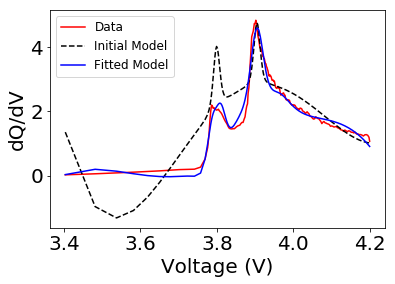

In [5]:
#evaluates fit using the default scipy.leastsquare method
model = mod.fit(sigy_bot, par, x=sigx_bot)

#generates a fit report containing fit parameters as well as error values
print(model.fit_report(min_correl=0.5))

#plots data
plt.plot(sigx_bot, sigy_bot, 'r')
plt.plot(sigx_bot, model.init_fit, 'k--')
plt.plot(sigx_bot, model.best_fit, 'b-')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV')
plt.rcParams.update({'font.size':20})
plt.legend(['Data', 'Initial Model', 'Fitted Model'], loc=2, fontsize=12)

#### Dictionary Organization

Once the model is finished, the generated model is processed into a dictionary of descriptors. Here is an example of code:

In [6]:
import numpy as np
coefficients = []

for k in np.arange(4):
#key calculation for coefficient collection
    coef = 'c' + str(k)
    #extracting coefficients from model object
    coefficients.append(model.best_values[coef])

#creates a dictionary of coefficients
desc = {'coefficients': coefficients}
if len(i) > 0:
    #generates numpy array for peak calculation
    sigx, sigy = descriptors.fitters.cd_dataframe(charge['Voltage(V)'], charge['Smoothed_dQ/dV'], 'c')
    
#determines peak location and height locations from raw data
    desc.update({'peakLocation(V)': sigx[i].tolist(), 'peakHeight(dQdV)': sigy[i].tolist()})
    #initiates loop to extract 
    sig = []
    for index in i:
        #determines appropriate string to call standard deviation object from model
        center, sigma, amplitude, fraction, comb = descriptors.fitters.label_gen(index)
        sig.append(model.best_values[sigma])

    #updates dictionary with sigma key and object
    desc.update({'peakSIGMA': sig})
    
desc

{'coefficients': [-17364.278007899207,
  18630.893781680712,
  -7479.944724248071,
  1331.6791086160297],
 'peakHeight(dQdV)': [2.038610057094546, 4.587797324421603],
 'peakLocation(V)': [3.79929780960083, 3.905078172683716],
 'peakSIGMA': [0.02045949549442505, 0.034412961741249415]}

## Process Class

These functions execute the lmfit peak fitting function and properly organize the pandas dataframe of descriptors. This pandas dataframe has the following form.

In [7]:
pd.DataFrame(columns=['names', 'ch_0', 'ch_1', '...', 'ch_18', 'dc_0', 'dc_1', '...', 'dc_18'])

,names,ch_0,ch_1,...,ch_18,dc_0,dc_1,...,dc_18


### Process class work flow

This call graph was generated on a set of two batteries with 16 cycles total. It shows the structure of the `descriptors` package when `ML_generate` is called.

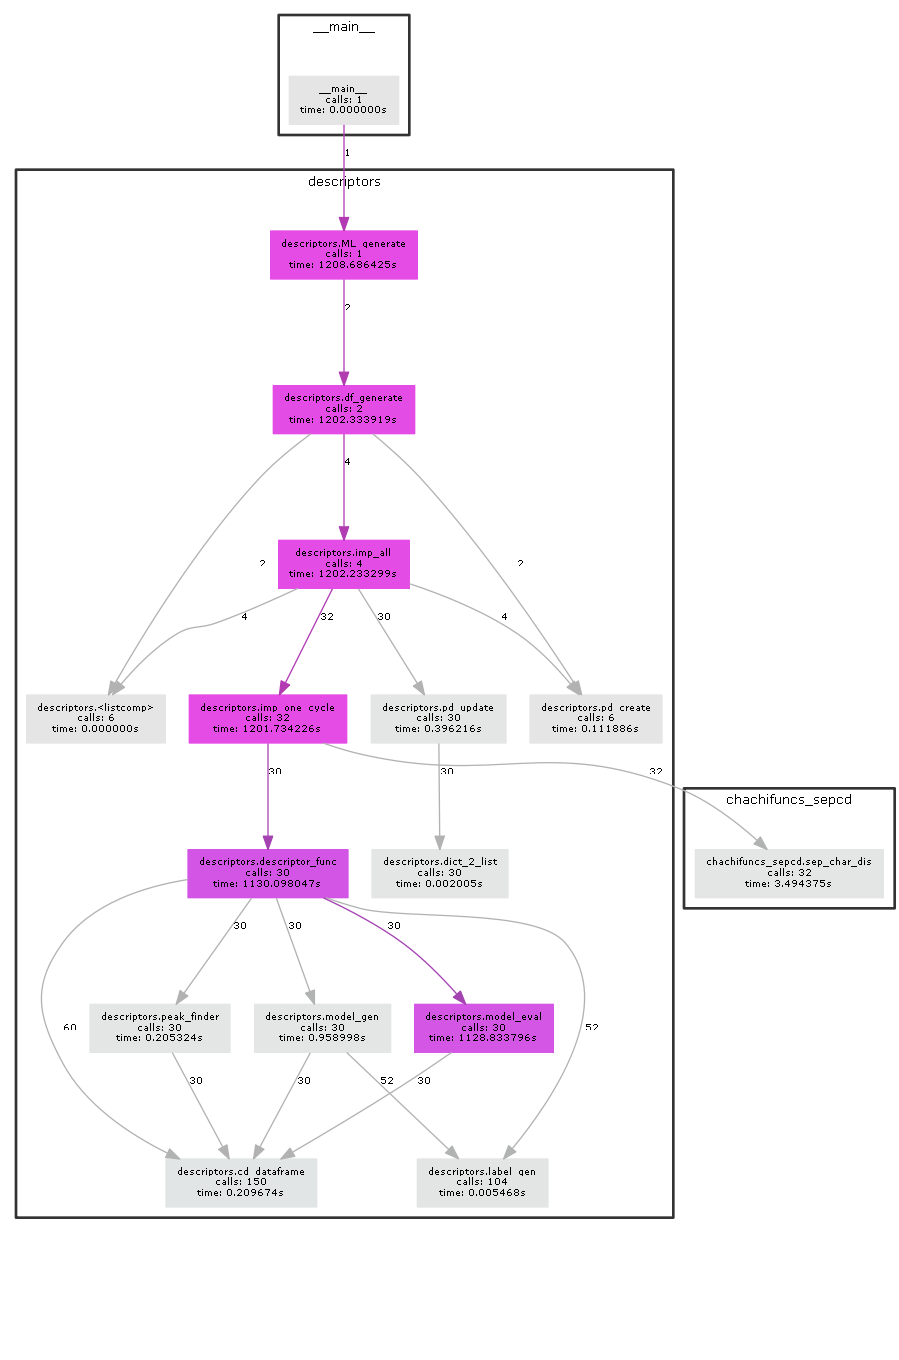

This figure was generated using the package `pycallgraph`. It can be found at the following GitHub repository: https://github.com/gak/pycallgraph/#python-call-graph

It is installable with the following lines in a python terminal:
```
pip install pycallgraph
pip install graphviz
```

In [10]:
from pycallgraph import PyCallGraph
from pycallgraph.output import GraphvizOutput

graphviz = GraphvizOutput(output_file='descriptors_class.png')

with PyCallGraph(output=graphviz):
    descriptors.ML_generate('example_files/Clean_Separated_Cycles')

Successfully extracted all battery names for c
Fitting battery: 7_24_13_1C_Cycle c
Cycle 51 in battery 7_24_13_1C_Cycle had fewer than 10 datapoints and was removed from the dataset.
Fitting battery: CS2_33_10_04_10 c
Fitting battery: CS2_33_12_23_10 c
Successfully extracted all battery names for d
Fitting battery: 7_24_13_1C_Cycle d
Cycle 51 in battery 7_24_13_1C_Cycle had fewer than 10 datapoints and was removed from the dataset.
Fitting battery: CS2_33_10_04_10 d
Fitting battery: CS2_33_12_23_10 d


# Final Output from Above Call

In [12]:
import pandas as pd
pd.read_excel('example_files/example_descriptors/describe.xlsx')

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,ch_9,...,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,dc_9
0,9868.294944,-11670.888110,5144.149631,-1001.406109,3.437595,13.739930,0.024356,0.000000,0.000000,0.000000,...,-2.143528e+03,3.140797e+03,-1697.051681,400.904288,3.169594,15.037665,0.026971,0.000000,0.000000,0.000000
0,15347.770929,-15496.207559,5840.356083,-973.742851,3.802538,1.939364,0.015992,3.912368,4.090270,0.027815,...,1.929360e+03,-2.140925e+03,879.686438,-158.685560,3.662901,4.000374,0.040572,3.595998,1.682794,0.004941
1,18810.911459,-19234.389739,7348.840506,-1243.481043,3.802862,1.971420,0.014489,3.909938,4.521553,0.026365,...,2.157023e+06,-2.128849e+06,787743.010036,-129526.121267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,97725.135183,-100033.886616,38330.558937,-6516.501742,3.932779,2.718488,0.018036,3.967121,2.716692,0.034785,...,1.571069e+03,-1.729486e+03,702.975543,-125.010103,3.646216,3.207695,0.048228,0.000000,0.000000,0.000000
1,132664.635763,-134249.988019,50889.016698,-8563.997022,3.934885,2.585210,0.021494,3.959669,2.719895,0.037818,...,1.545245e+03,-1.697396e+03,688.354627,-122.101667,3.643138,3.039284,0.048720,0.000000,0.000000,0.000000
2,108326.386385,-109514.237310,41469.767346,-6971.247333,3.929377,2.592342,0.017611,3.952866,2.591363,0.046552,...,1.553563e+03,-1.705829e+03,691.505201,-122.621394,3.651075,3.173895,0.048971,0.000000,0.000000,0.000000


## Descriptor Key

the 'ch_' prefix is for the charge descriptors and will be used in this table as 'pref':

DataFrame Entry | Descriptors
------|------
pref_0 to pref_3 | polynomial coefficient in order of degree
pref_4, 7, 10, ... | peak location (V)
pref_5, 8, 11, ... | peak height (dQ/dV)
pref_6, 9, 12, ... | peak $\sigma$

### Descriptor Plotting

In [13]:
df = pd.read_excel('example_files/example_descriptors/CS2_33_10_04_10-12_23_10.xlsx')
bat1 = df.iloc[0:22, :]

bat2 = df.iloc[23:, :]

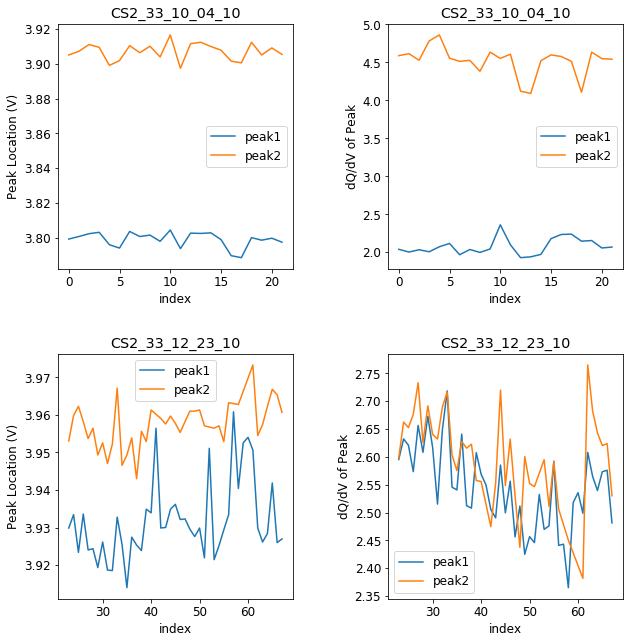

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5)

#plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size':12})
#first and second peak location for the first battery
axes[0, 0].plot(bat1.index, bat1['ch_4'], bat1.index, bat1['ch_7'])
axes[0, 0].set_title('CS2_33_10_04_10')
axes[0, 0].set_xlabel('index')
axes[0, 0].set_ylabel('Peak Location (V)')
axes[0, 0].legend(['peak1', 'peak2'])

#first and second peak height for the first battery
axes[0, 1].plot(bat1.index, bat1['ch_5'], bat1.index, bat1['ch_8'])
axes[0, 1].set_title('CS2_33_10_04_10')
axes[0, 1].set_xlabel('index')
axes[0, 1].set_ylabel('dQ/dV of Peak')
axes[0, 1].legend(['peak1', 'peak2'])

#first and second peak location for the second battery
axes[1, 0].plot(bat2.index, bat2['ch_4'], bat2['ch_7'][bat2['ch_7']!=0].index, bat2['ch_7'][bat2['ch_7']!=0])
axes[1, 0].set_title('CS2_33_12_23_10')
axes[1, 0].set_xlabel('index')
axes[1, 0].set_ylabel('Peak Location (V)')
axes[1, 0].legend(['peak1', 'peak2'])

#first and second peak height for the second battery
axes[1, 1].plot(bat2.index, bat2['ch_5'], bat2['ch_8'][bat2['ch_8']!=0].index, bat2['ch_8'][bat2['ch_8']!=0])
axes[1, 1].set_title('CS2_33_12_23_10')
axes[1, 1].set_xlabel('index')
axes[1, 1].set_ylabel('dQ/dV of Peak')
axes[1, 1].legend(['peak1', 'peak2'])